# **DATA MODELLING**


Before running the cells in this notebook make sure you download all the important FARS data by running the **download_fars.py** code inside the **/notebooks** folder

This notebook builds a complete modelling pipeline to estimate how weather patterns influence vehicle crash rates across U.S. states from 2010–2023.

The workflow includes:

- Loading yearly accident datasets
- Aggregating and cleaning crash counts
- Loading VMT (Vehicle Miles Traveled) information
- Fetching daily historical weather data using the Open-Meteo API
- Computing annual weather summaries for each state
- Merging crash, climate, and VMT data
- Engineering features for modelling
- Training predictive models for crash rates and total crashes
- Evaluating model performance with multiple visualizations

This notebook forms the foundation for understanding long-term climatic impacts on transportation safety.


### 1. Load data paths


In [1]:
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import requests
import time
import json
import hashlib
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

project_root = Path(os.getcwd()).parents[0]
data_folder = project_root / 'data' / 'data_accidents'

### 2. Generate `total_crashes.csv` for each year

Every annual folder inside `data/data_accidents/<YEAR>` contains an `accident.csv` file with individual crash records.  
To create a consistent summary dataset, this step:

1. Iterates through all available year folders 1975-2023
2. Loads the accident dataset for each year
3. Calculates total crashes per state for each year
4. Saves the summary as `total_crashes.csv` in `data/data_accidents` folder


In [2]:
all_years = []

years = sorted([f for f in data_folder.iterdir() if f.is_dir()])

for year_folder in tqdm(years, desc="Processing years", unit="year"):
    year = year_folder.name
    acc_file = year_folder / 'accident.csv'

    if not acc_file.exists():
        continue

    try:
        df = pd.read_csv(acc_file, low_memory=False, encoding="utf-8")
    except UnicodeDecodeError:
        df = pd.read_csv(acc_file, low_memory=False, encoding="latin1")

    if 'STATE' not in df.columns:
        tqdm.write(f"No STATE column found in {year}, skipping")
        continue

    total = df.groupby('STATE').size().reset_index(name='total_crashes')
    total['year'] = int(year)
    total.rename(columns={'STATE': 'state'}, inplace=True)

    all_years.append(total)

df_total = pd.concat(all_years, ignore_index=True)

df_total = df_total.sort_values(["year", "state"])

out_path = data_folder / "total_crashes.csv"
df_total.to_csv(out_path, index=False)

print(f"\nCombined file saved to: {out_path}")

Processing years:   0%|          | 0/53 [00:00<?, ?year/s]

Processing years: 100%|██████████| 53/53 [00:27<00:00,  1.96year/s]


Combined file saved to: c:\Users\zualuk\OneDrive - fer.hr\Desktop\USA_accidents_data_science\data\data_accidents\total_crashes.csv


### 3. State centroids

Since USA has 51 states and they are really big, it is very challenging to collect weather data. So, to query weather information, each state is represented by a **centorid** with a latitude/longitude coordinate. This section loads a dataset of state geographic centroids, which serve as the input locations for historical weather API requests.


In [3]:
STATE_CENTROIDS = {
    1: (32.3182, -86.9023),   # Alabama
    2: (64.2008, -149.4853),  # Alaska
    4: (34.0489, -111.0937),  # Arizona
    5: (34.7996, -92.1849),   # Arkansas
    6: (37.2719, -119.2702),  # California
    8: (39.5501, -105.7821),  # Colorado
    9: (41.6032, -73.0877),   # Connecticut
    10: (39.1398, -75.5052),  # Delaware
    11: (38.8974, -77.0268),  # District of Columbia
    12: (27.6648, -81.5158),  # Florida
    13: (32.1656, -82.9001),  # Georgia
    15: (19.8968, -155.5828), # Hawaii
    16: (44.0682, -114.7420), # Idaho
    17: (39.7837, -89.6501),  # Illinois
    18: (39.7910, -86.1490),  # Indiana
    19: (41.8780, -93.0977),  # Iowa
    20: (38.5266, -96.7265),  # Kansas
    21: (37.8393, -85.7170),  # Kentucky
    22: (31.2448, -92.1450),  # Louisiana
    23: (45.2538, -69.4455),  # Maine
    24: (39.0458, -76.6413),  # Maryland
    25: (42.4072, -71.3824),  # Massachusetts
    26: (43.3266, -84.5361),  # Michigan
    27: (45.6945, -93.9002),  # Minnesota
    28: (32.3547, -90.0602),  # Mississippi
    29: (38.5443, -92.2884),  # Missouri
    30: (46.9653, -110.0845), # Montana
    31: (41.4925, -99.9018),  # Nebraska
    32: (38.8026, -116.4194), # Nevada
    33: (43.1939, -71.5724),  # New Hampshire
    34: (40.2237, -74.7647),  # New Jersey
    35: (34.5199, -106.0186), # New Mexico
    36: (42.7512, -75.7634),  # New York
    37: (35.7718, -80.0211),  # North Carolina
    38: (47.5515, -100.4659), # North Dakota
    39: (40.4173, -82.9071),  # Ohio
    40: (35.0078, -97.0929),  # Oklahoma
    41: (44.0009, -120.5542), # Oregon
    42: (40.5908, -77.2098),  # Pennsylvania
    44: (41.5801, -71.4774),  # Rhode Island
    45: (33.8361, -81.1637),  # South Carolina
    46: (44.5000, -100.0000), # South Dakota
    47: (35.5175, -86.5804),  # Tennessee
    48: (31.9686, -99.9018),  # Texas
    49: (40.1500, -111.8625), # Utah
    50: (44.5588, -72.5778),  # Vermont
    51: (37.4316, -78.6569),  # Virginia
    53: (47.7511, -120.7401), # Washington
    54: (38.5976, -80.4549),  # West Virginia
    55: (44.5000, -89.5000),  # Wisconsin
    56: (43.0000, -107.5000)  # Wyoming
}

### 4. Fetch historical weather data

Here we retrieve daily historical weather data from the **Open-Meteo API**.  
The pipeline performs the following tasks:

- Initializes a cached HTTP session to avoid repeated API calls
- Queries daily weather variables for each state across all years
- Retrieves climate variables such as:
  - Temperature
  - Precipitation
  - Wind speed

The result is a large daily-resolution dataset of weather conditions for every state centroid from 1975-2023.


In [ ]:
state_full_dir = data_folder / "state_full_json"
state_yearly_dir = data_folder / "state_yearly_json"

os.makedirs(state_full_dir, exist_ok=True)
os.makedirs(state_yearly_dir, exist_ok=True)

cache_session = requests_cache.CachedSession('.cache', expire_after = 86400)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

START_YEAR = 1975
END_YEAR = 2023

def fetch_full_period(lat, lon):
    """Fetch 1975-2023 daily climate data for one location in one call"""
    url = "https://climate-api.open-meteo.com/v1/climate"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{START_YEAR}-01-01",
        "end_date": f"{END_YEAR}-12-31",
        "models": "CMCC_CM2_VHR4",
        "timezone": "UTC",
        "daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_mean"]
    }
    return openmeteo.weather_api(url, params=params)[0]

yearly_records = []

for state_id, (lat, lon) in STATE_CENTROIDS.items():

    print(f"Fetching full 1975-2023 for state {state_id}")

    try:
        response = fetch_full_period(lat, lon)
    except Exception as e:
        print(f"Error fetching state {state_id}: {e}")
        continue

    daily = response.Daily()
    temp = daily.Variables(0).ValuesAsNumpy()
    prec = daily.Variables(1).ValuesAsNumpy()
    wind = daily.Variables(2).ValuesAsNumpy()

    dates = pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )

    df_daily = pd.DataFrame({
        "date": dates.astype(str),
        "temperature_2m_mean": temp,
        "precipitation_sum": prec,
        "wind_speed_10m_mean": wind
    })
    df_daily["year"] = pd.to_datetime(df_daily["date"]).dt.year

    out_full_path = state_full_dir / f"STATE_{state_id}_1975_2023.json"

    json_obj = {
        "state_id": state_id,
        "latitude": lat,
        "longitude": lon,
        "years": f"{START_YEAR}-{END_YEAR}",
        "daily": df_daily.to_dict(orient="records")
    }
    with open(out_full_path, "w") as f:
        json.dump(json_obj, f, indent=2)

    df_yearly = df_daily.groupby("year").agg({
        "temperature_2m_mean": "mean",
        "precipitation_sum": "sum",
        "wind_speed_10m_mean": "mean"
    }).reset_index()

    df_yearly["state_id"] = state_id
    df_yearly["latitude"] = lat
    df_yearly["longitude"] = lon

    for _, row in df_yearly.iterrows():
        yearly_records.append({
            "state_id": int(row["state_id"]),
            "year": int(row["year"]),
            "avg_temp_c": float(row["temperature_2m_mean"]),
            "total_precip_mm": float(row["precipitation_sum"]),
            "avg_wind_speed_ms": float(row["wind_speed_10m_mean"]),
            "latitude": float(lat),
            "longitude": float(lon)
        })

yearly_jsonl_path = state_yearly_dir / "state_yearly_1975_2023.jsonl"

with open(yearly_jsonl_path, "w") as outfile:
    for rec in yearly_records:
        outfile.write(json.dumps(rec) + "\n")

print("Done, all states processed")
print("Daily data saved in: state_full_json/")
print("Yearly JSONL saved: state_yearly_json/state_yearly_1975_2023.jsonl")


Fetching full 1975-2023 for state 1
Fetching full 1975-2023 for state 2
Fetching full 1975-2023 for state 4
Fetching full 1975-2023 for state 5
Fetching full 1975-2023 for state 6
Fetching full 1975-2023 for state 8
Fetching full 1975-2023 for state 9
Fetching full 1975-2023 for state 10
Fetching full 1975-2023 for state 11
Fetching full 1975-2023 for state 12
Fetching full 1975-2023 for state 13
Fetching full 1975-2023 for state 15
Fetching full 1975-2023 for state 16
Fetching full 1975-2023 for state 17
Fetching full 1975-2023 for state 18
Fetching full 1975-2023 for state 19
Fetching full 1975-2023 for state 20
Fetching full 1975-2023 for state 21
Fetching full 1975-2023 for state 22
Fetching full 1975-2023 for state 23
Fetching full 1975-2023 for state 24
Fetching full 1975-2023 for state 25
Fetching full 1975-2023 for state 26
Fetching full 1975-2023 for state 27
Fetching full 1975-2023 for state 28
Fetching full 1975-2023 for state 29
Fetching full 1975-2023 for state 30
Fetching

### 5. Combining crashes and weather data into `final_accidents.csv`


In [4]:
data_folder = project_root / 'data' / 'data_accidents'
yearly_jsonl_path = data_folder / "state_yearly_json" / "state_yearly_1975_2023.jsonl"
crashes_csv_path = data_folder / "total_crashes.csv"

climate_records = []
with open(yearly_jsonl_path, "r") as f:
    for line in f:
        climate_records.append(json.loads(line))

df_climate = pd.DataFrame(climate_records)
print("Climate sample:")
display(df_climate.head())


df_crashes = pd.read_csv(crashes_csv_path)
print("Crashes sample:")
display(df_crashes.head())


df_crashes = df_crashes.rename(columns={"state": "state_id"})

df_final = df_crashes.merge(
    df_climate,
    on=["state_id", "year"],
    how="left"
)

STATE_NAMES = {
    1: "Alabama",
    2: "Alaska",
    4: "Arizona",
    5: "Arkansas",
    6: "California",
    8: "Colorado",
    9: "Connecticut",
    10: "Delaware",
    11: "District of Columbia",
    12: "Florida",
    13: "Georgia",
    15: "Hawaii",
    16: "Idaho",
    17: "Illinois",
    18: "Indiana",
    19: "Iowa",
    20: "Kansas",
    21: "Kentucky",
    22: "Louisiana",
    23: "Maine",
    24: "Maryland",
    25: "Massachusetts",
    26: "Michigan",
    27: "Minnesota",
    28: "Mississippi",
    29: "Missouri",
    30: "Montana",
    31: "Nebraska",
    32: "Nevada",
    33: "New Hampshire",
    34: "New Jersey",
    35: "New Mexico",
    36: "New York",
    37: "North Carolina",
    38: "North Dakota",
    39: "Ohio",
    40: "Oklahoma",
    41: "Oregon",
    42: "Pennsylvania",
    44: "Rhode Island",
    45: "South Carolina",
    46: "South Dakota",
    47: "Tennessee",
    48: "Texas",
    49: "Utah",
    50: "Vermont",
    51: "Virginia",
    53: "Washington",
    54: "West Virginia",
    55: "Wisconsin",
    56: "Wyoming"
}

df_state_names = pd.DataFrame(list(STATE_NAMES.items()), columns=["state_id", "state_name"])
df_final = df_final.merge(df_state_names, on="state_id", how="left")

df_final = df_final[[
    "state_name", "state_id", "year", "total_crashes",
    "avg_temp_c", "total_precip_mm", "avg_wind_speed_ms",
    "latitude", "longitude"
]]

print("Merged sample:")
display(df_final.head())

output_path = data_folder / "final_accidents.csv"
df_final.to_csv(output_path, index=False)

print("Saved updated dataset with state names to:", output_path)

Climate sample:


,state_id,year,avg_temp_c,total_precip_mm,avg_wind_speed_ms,latitude,longitude
0,1,1975,18.289001,778.931335,8.879612,32.3182,-86.9023
1,1,1976,19.057867,909.586670,9.066879,32.3182,-86.9023
2,1,1977,18.061195,1072.445557,8.622186,32.3182,-86.9023
3,1,1978,17.753811,824.878418,9.210961,32.3182,-86.9023
4,1,1979,18.060509,816.138367,9.007619,32.3182,-86.9023


Crashes sample:


,state,total_crashes,year
0,1,765,1975
1,2,98,1975
2,4,593,1975
3,5,475,1975
4,6,3667,1975


Merged sample:


,state_name,state_id,year,total_crashes,avg_temp_c,total_precip_mm,avg_wind_speed_ms,latitude,longitude
0,Alabama,1,1975,765,18.289001,778.931335,8.879612,32.3182,-86.9023
1,Alaska,2,1975,98,-3.858101,395.137085,8.587646,64.2008,-149.4853
2,Arizona,4,1975,593,13.881677,500.400269,7.351995,34.0489,-111.0937
3,Arkansas,5,1975,475,17.206207,948.870544,10.324337,34.7996,-92.1849
4,California,6,1975,3667,4.178099,945.074402,5.709918,37.2719,-119.2702


Saved updated dataset with state names to: c:\Users\zualuk\OneDrive - fer.hr\Desktop\USA_accidents_data_science\data\data_accidents\final_accidents.csv


### 6. Download & load VMT data


Why VMT (Vehicle Miles Traveled)?

So far, our dataset `final_accidents.csv` contains the total number of fatal crashes per state and year, along with weather and geographic features. While this is useful, it has a critical limitation: Total crashes are driven largely by how much people drive, not just by how dangerous driving conditions are.

For example, California consistently reports more fatal crashes than Wyoming - but this is mostly because far more miles are driven in California.

To isolate the true effect of weather on crash risk, we need to account for exposure: the total amount of driving occurring in a state each year.

In transportation safety research, the standard metric for exposure is **Vehicle Miles Traveled (VMT) - the total number of miles driven by all vehicles in a state during a year.**

We use VMT to compute the **fatal crash rate**:

$$
\text{Crash Rate} = \frac{\text{Total Fatal Crashes}}{\text{VMT}} \times 100{,}000{,}000
$$

This gives us **fatal crashes per 100 million vehicle miles traveled** - the **official safety metric** used by the U.S. Department of Transportation (DOT), NHTSA, and FHWA.


Our model will capture whether hotter, wetter, or windier years actually make **each mile driven more dangerous**.
Just a small note: **We have VMT data for each state from 1980 until 2023**


In [5]:
project_root = Path(os.getcwd()).parents[0]
vmt_folder = project_root / "data" / "vmt"
data_acc_folder = project_root / "data" / "data_accidents"
vmt_raw_path = vmt_folder / "VMT_original.csv"
accidents_path = data_acc_folder / "final_accidents.csv"
output_path = data_acc_folder / "final_accidents_with_vmt.csv"

df_vmt_raw = pd.read_csv(vmt_raw_path)

# Sum VMT across all road types (Area + FClass) for each state and year
df_vmt_total = df_vmt_raw.groupby(['Year', 'State'])['VMT'].sum().reset_index()
df_vmt_total.rename(columns={'Year': 'year', 'State': 'state_name', 'VMT': 'vmt'}, inplace=True)

# reverses a dictionary, changing it from (FIPS: State Name) into (State Name: FIPS)
NAME_TO_FIPS = {name: fips for fips, name in STATE_NAMES.items()}

df_vmt_total['state_id'] = df_vmt_total['state_name'].map(NAME_TO_FIPS)
unmapped = df_vmt_total[df_vmt_total['state_id'].isna()]['state_name'].unique()
if len(unmapped) > 0:
    print(f"\nWarning: These states were not mapped to FIPS codes: {unmapped}")
else:
    print("\nAll states successfully mapped to FIPS codes")

# Drop rows where state_id is NaN (e.g., Puerto Rico which is also part of the dataset, but we don't need it)
df_vmt_total = df_vmt_total.dropna(subset=['state_id'])
df_vmt_total['state_id'] = df_vmt_total['state_id'].astype(int)

### 7. Merge VMT with accident data


In [6]:
# Ensure state_id is integer in BOTH datasets
df_vmt_total['state_id'] = df_vmt_total['state_id'].astype(int)
df_acc = df_final.copy()
df_acc['state_id'] = df_acc['state_id'].astype(int)

# Merge on state_id and year
df_final = pd.merge(
    df_acc,
    df_vmt_total[['state_id', 'year', 'vmt']],
    on=['state_id', 'year'],
    how='inner'  # Only keep years/states present in BOTH
)

print(f"\nSuccessfully merged! Final shape: {df_final.shape}")
print("Years covered:", df_final['year'].min(), "to", df_final['year'].max())
print("States covered:", df_final['state_name'].nunique())
df_final.head()


Successfully merged! Final shape: (2244, 10)
Years covered: 1980 to 2023
States covered: 51


,state_name,state_id,year,total_crashes,avg_temp_c,total_precip_mm,avg_wind_speed_ms,latitude,longitude,vmt
0,Alabama,1,1980,835,18.045027,1235.245361,8.992018,32.3182,-86.9023,2.902700e+10
1,Alaska,2,1980,79,-1.734674,466.319275,8.910186,64.2008,-149.4853,2.665000e+09
2,Arizona,4,1980,833,13.420449,758.078552,7.187393,34.0489,-111.0937,1.793100e+10
3,Arkansas,5,1980,486,16.949562,855.259521,9.794807,34.7996,-92.1849,1.623200e+10
4,California,6,1980,4930,3.937228,1035.248413,5.442434,37.2719,-119.2702,1.558900e+11


### 8. Compute crash rate per 100 million VMT

After computing crash rate per 100 million VMT, the data is merged with accident data and saved into: `data/data_accidents/final_accidents_with_vmt.csv`


In [7]:
df_final['crash_rate_per_100m_vmt'] = (df_final['total_crashes'] / df_final['vmt']) * 100_000_000

# Remove any invalid rows (should be none, but to stay safe)
df_final = df_final[df_final['vmt'] > 0].reset_index(drop=True)

print("\nCrash rate computed! Sample:")
print(df_final[['state_name', 'year', 'total_crashes', 'vmt', 'crash_rate_per_100m_vmt']].head())

output_path = project_root / "data" / "data_accidents" / "final_accidents_with_vmt.csv"
df_final.to_csv(output_path, index=False)

print(f"Final dataset saved successfully to:\n{output_path}")
print(f"Dataset shape: {df_final.shape}")
print(f"Columns: {list(df_final.columns)}")


Crash rate computed! Sample:
   state_name  year  total_crashes           vmt  crash_rate_per_100m_vmt
0     Alabama  1980            835  2.902700e+10                 2.876632
1      Alaska  1980             79  2.665000e+09                 2.964353
2     Arizona  1980            833  1.793100e+10                 4.645586
3    Arkansas  1980            486  1.623200e+10                 2.994086
4  California  1980           4930  1.558900e+11                 3.162486
Final dataset saved successfully to:
c:\Users\zualuk\OneDrive - fer.hr\Desktop\USA_accidents_data_science\data\data_accidents\final_accidents_with_vmt.csv
Dataset shape: (2244, 11)
Columns: ['state_name', 'state_id', 'year', 'total_crashes', 'avg_temp_c', 'total_precip_mm', 'avg_wind_speed_ms', 'latitude', 'longitude', 'vmt', 'crash_rate_per_100m_vmt']


## Visualizing the _National Crash Rate Trend (1980–2023)_


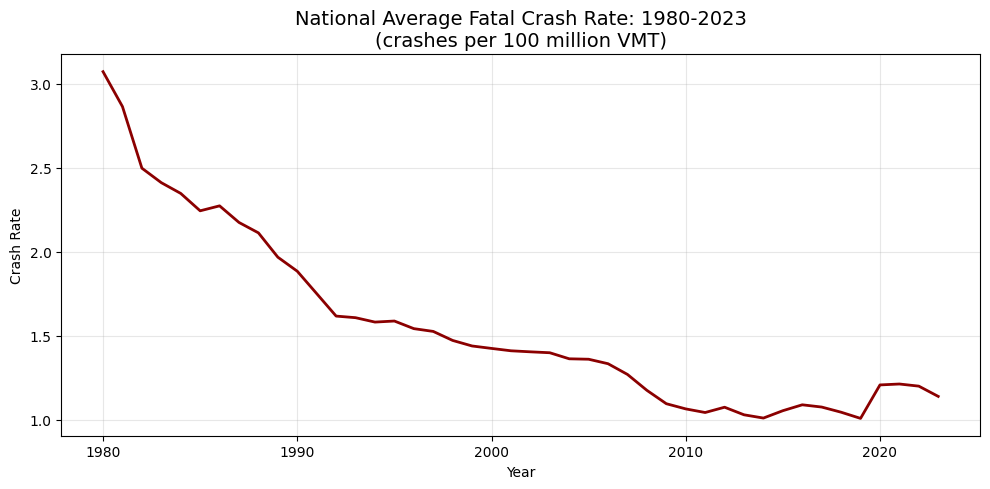

In [8]:
project_root = Path(os.getcwd()).parents[0]
df = pd.read_csv(project_root / "data" / "data_accidents" / "final_accidents_with_vmt.csv")

national_trend = df.groupby('year')['crash_rate_per_100m_vmt'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(national_trend['year'], national_trend['crash_rate_per_100m_vmt'],
         color='darkred', linewidth=2)
plt.title('National Average Fatal Crash Rate: 1980-2023\n(crashes per 100 million VMT)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Crash Rate')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The fatal crash rate per 100 million vehicle miles traveled (VMT) has **declined dramatically** since the 1980s - dropping from over 3.0 to around 1.1–1.2 in recent years.

This reflects decades of progress in automotive safety, including seat belts, airbags, anti-lock brakes, automated emergency braking, stricter drunk-driving laws, and improved road design. Despite rising vehicle miles traveled and increased distractions (e.g., smartphones), the risk per mile driven has fallen by nearly 65%.

After decades of decline, the fatal crash rate began rising again, with a notable increase by 2018, likely due to distracted driving, larger vehicles, and more extreme weather.


## _Crash Rate vs. Average Temperature_

This visualization explores the relationship between a state's average yearly temperature and its crash rate.  
Each point represents a state-year observation, and the scatter cloud shows the overall distribution.

A regression line is added to try to highlight the general trend. This helps reveal whether warmer or cooler climates are associated with higher crash risk, providing an initial look at how temperature may influence driving safety.


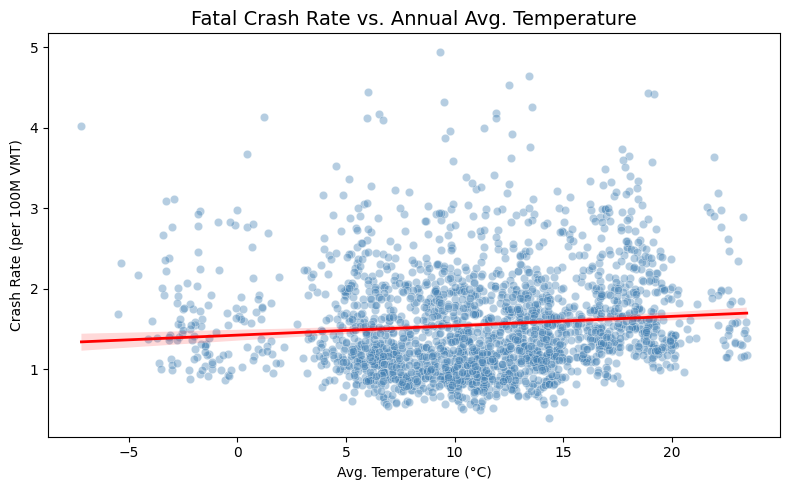

In [9]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='avg_temp_c',
    y='crash_rate_per_100m_vmt',
    alpha=0.4,
    color='steelblue'
)
# Add trend line
sns.regplot(
    data=df,
    x='avg_temp_c',
    y='crash_rate_per_100m_vmt',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)
plt.title('Fatal Crash Rate vs. Annual Avg. Temperature', fontsize=14)
plt.xlabel('Avg. Temperature (°C)')
plt.ylabel('Crash Rate (per 100M VMT)')
plt.tight_layout()
plt.show()

### **Conclusion**

The plot shows a very weak positive relationship between average temperature and fatal crash rates. While warmer states and years tend to have slightly higher crash rates, the data points are widely scattered around the trend line, indicating that temperature alone explains only a very very small portion of the variation. In short, higher temperatures are associated with a modest increase in fatal crashes, but the relationship is very weak and likely influenced by many other factors, which we will look at.


## _Crash Rate vs. Precipitation_


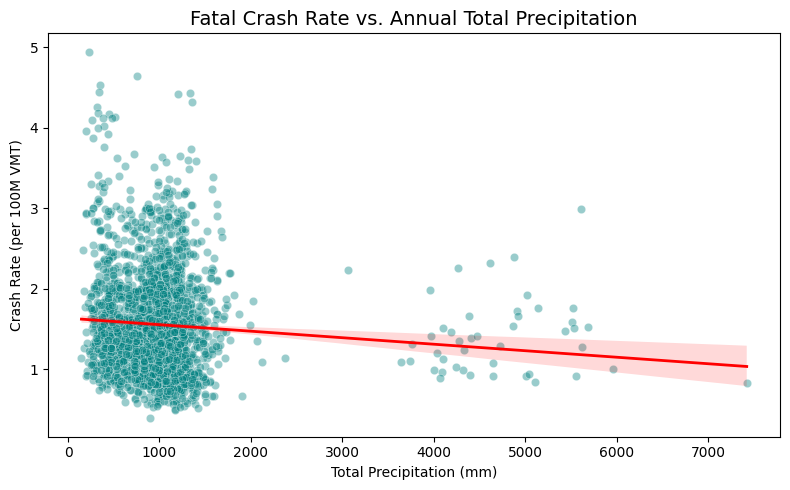

In [10]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='total_precip_mm',
    y='crash_rate_per_100m_vmt',
    alpha=0.4,
    color='teal'
)
sns.regplot(
    data=df,
    x='total_precip_mm',
    y='crash_rate_per_100m_vmt',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2}
)
plt.title('Fatal Crash Rate vs. Annual Total Precipitation', fontsize=14)
plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Crash Rate (per 100M VMT)')
plt.tight_layout()
plt.show()

### **Conclusion**

The plot shows a weak negative relationship between total year precipitation and fatal crash rates. As precipitation increases, the crash rate tends to decrease slightly, although the data is widely scattered - especially at lower precipitation levels - indicating that precipitation alone is not a strong predictor of fatal crash risk. One possible explanation for the slight downward trend is that during rainy or wet conditions, drivers may slow down or behave more cautiously, which could help reduce the likelihood of severe crashes. Overall, wetter states and years appear to have marginally lower fatal crash rates, but the effect is small and influenced by many other factors.


## _Visualization of Average Crash Rate by State_

This chart highlights the long-term average fatal crash rate for each U.S. state from 1980 to 2023, normalized by vehicle miles traveled. Visualizing states side-by-side reveals substantial variation in crash risk across the U.S.

Such a comparison is useful for several reasons:

- **Identifying high-risk states:** States at the bottom of the chart have consistently higher fatal crash rates, indicating potential issues related to road safety, infrastructure, enforcement, or environmental factors.
- **Benchmarking performance:** States with lower crash rates can serve as models for effective safety policies, roadway design, or public health interventions.
- **Understanding regional patterns:** Differences may reflect climate, urbanization levels, driving culture, or socioeconomic conditions.
- **Policy and resource allocation:** Transportation agencies can use this information to prioritize safety investments or target interventions where fatal crash risk has historically been higher.

Overall, the chart provides a clear overview of how fatal crash risk varies geographically and helps guide deeper investigation into the underlying causes of these differences.


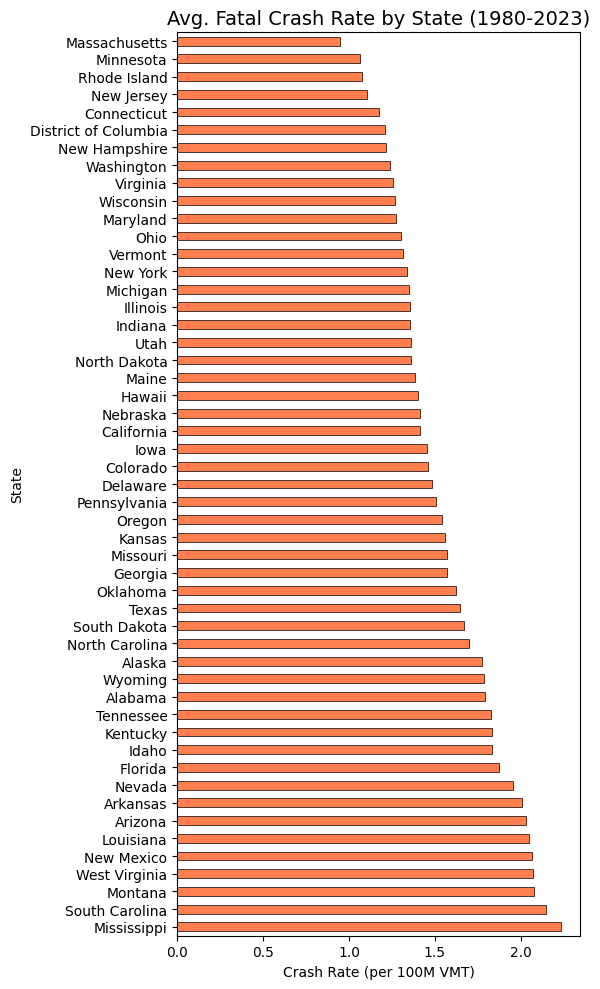

In [11]:
state_rates = df.groupby('state_name')['crash_rate_per_100m_vmt'].mean().sort_values(ascending=False)

plt.figure(figsize=(6, 10))
state_rates.plot(kind='barh', color='coral', edgecolor='black', linewidth=0.5)
plt.title('Avg. Fatal Crash Rate by State (1980-2023)', fontsize=14)
plt.xlabel('Crash Rate (per 100M VMT)')
plt.ylabel('State')
plt.tight_layout()
plt.show()

## _Taking a deeper look at some countries_


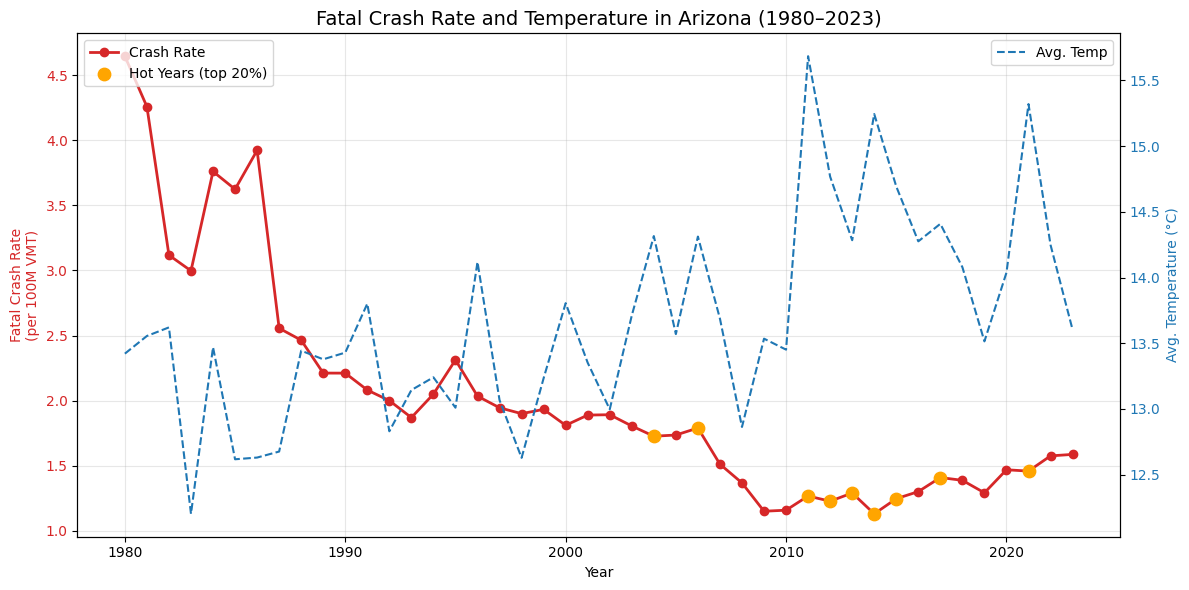

In [12]:
STATE = "Arizona"

state_data = df[df['state_name'] == STATE].copy()
state_data = state_data.sort_values('year')

fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Fatal Crash Rate\n(per 100M VMT)', color=color)
ax1.plot(state_data['year'], state_data['crash_rate_per_100m_vmt'],
         color=color, marker='o', linewidth=2, label='Crash Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Avg. Temperature (°C)', color=color)
ax2.plot(state_data['year'], state_data['avg_temp_c'],
         color=color, linestyle='--', linewidth=1.5, label='Avg. Temp')
ax2.tick_params(axis='y', labelcolor=color)

hot_threshold = state_data['avg_temp_c'].quantile(0.8)  # top 20% hottest
hot_years = state_data[state_data['avg_temp_c'] >= hot_threshold]
ax1.scatter(hot_years['year'], hot_years['crash_rate_per_100m_vmt'],
            color='orange', s=80, zorder=5, label='Hot Years (top 20%)')

plt.title(f'Fatal Crash Rate and Temperature in {STATE} (1980–2023)', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout()
plt.show()

This graph shows how the fatal crash rate (per 100 million vehicle miles traveled) and average annual temperature have changed over time in a single U.S. state - for example, Arizona - from 1980 to 2023. The red line represents the state’s yearly fatal crash risk, while the blue dashed line shows the average temperature for that same year. Orange dots highlight the state’s hottest years (top 20% of temperatures during this period).

We can see that Arizona’s fatal crash rate has generally declined. Although temperatures have trended upward over time and several of the hottest years are marked, there is no strong or consistent pattern showing that hotter years correspond to notably higher fatal crash rates. Some hot years align with slightly elevated crash rates, but others occur during relatively low-risk periods.

Overall, the relationship between temperature and fatal crash risk in Arizona appears weak and inconsistent. Long-term improvements in vehicle safety, road engineering, and enforcement likely play a larger role in shaping the downward trend in fatal crash rates than annual fluctuations in temperature.


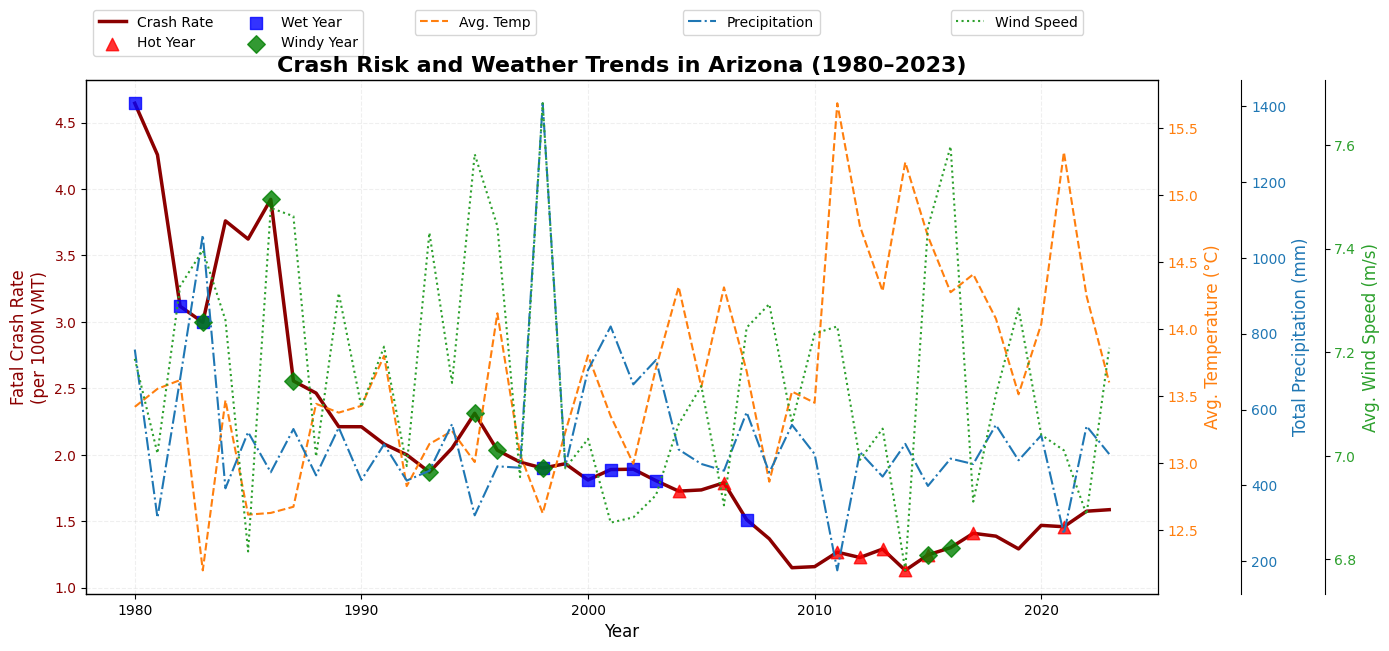

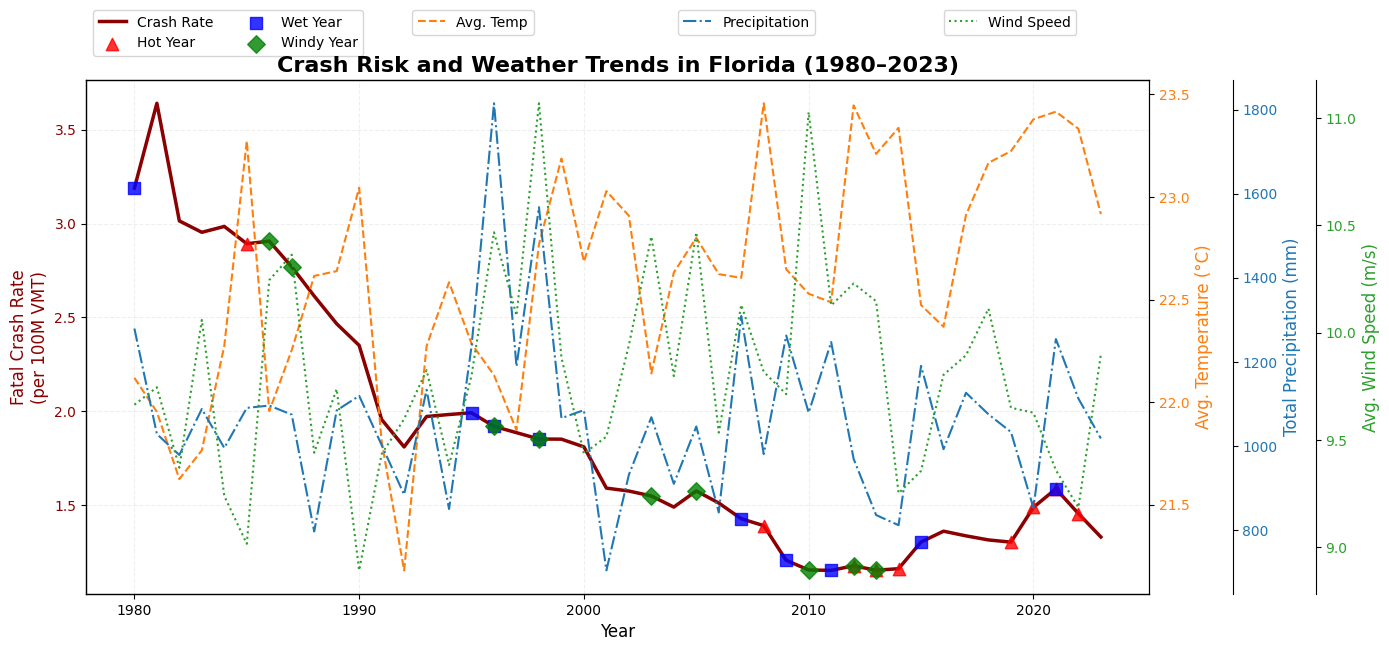

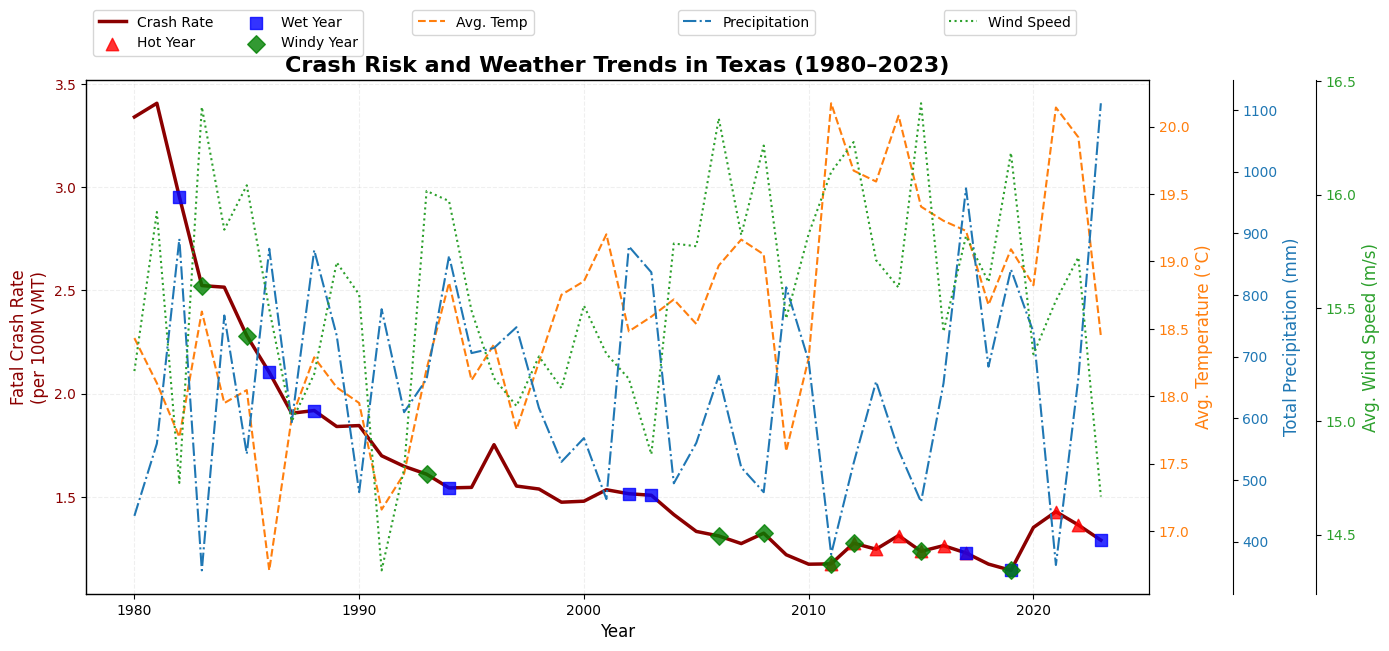

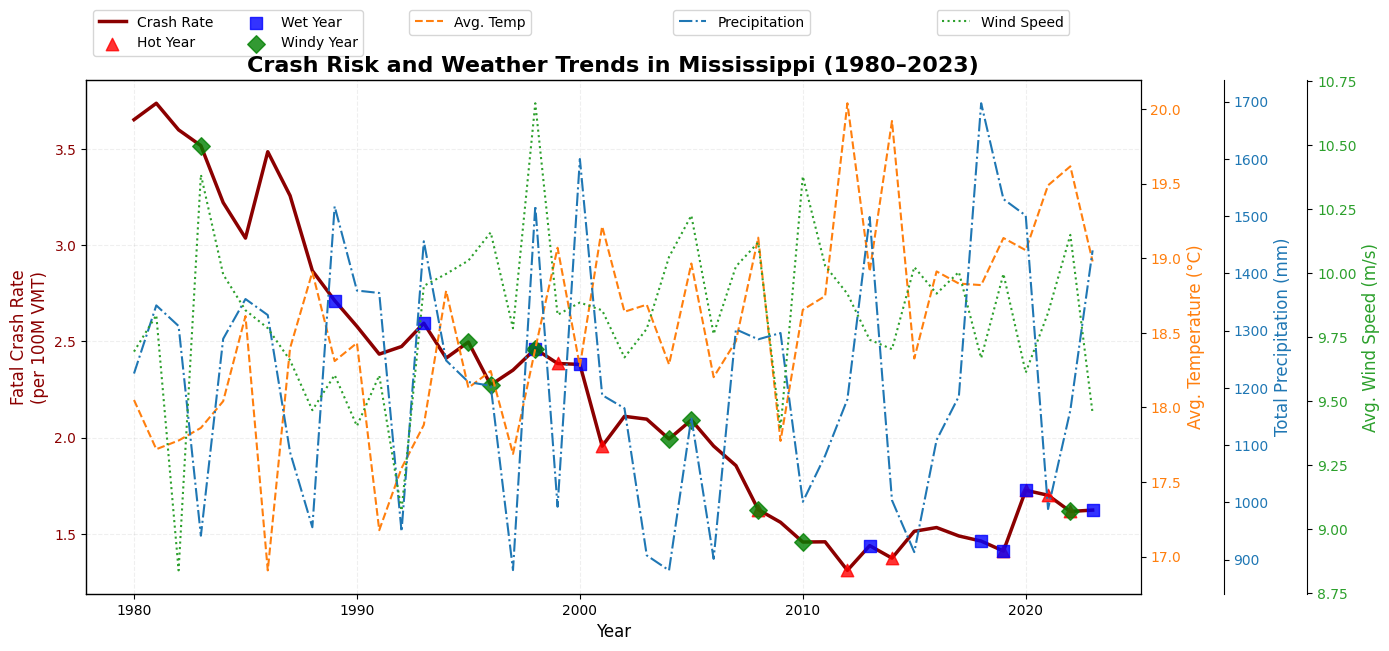

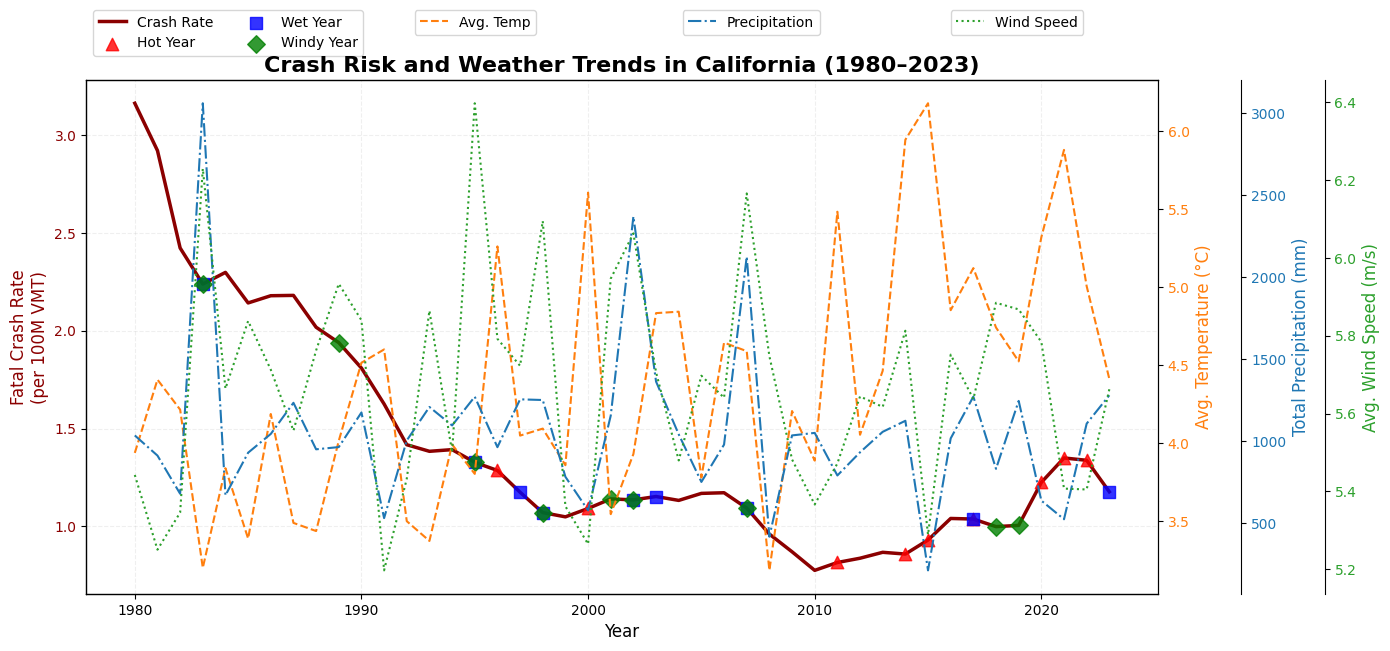

In [13]:
def plot_weather_crash_trends(df, state_name):
    """
    Create a multi-axis time series plot showing crash rate and weather variables for a single state

    Parameters:
    - df: DataFrame with columns ['state_name', 'year', 'crash_rate_per_100m_vmt',
                                 'avg_temp_c', 'total_precip_mm', 'avg_wind_speed_ms']
    - state_name: Name of the state to plot (e.g., "Arizona", "Texas", "Florida")
    """
    state_data = df[df['state_name'] == state_name].sort_values('year').copy()

    if state_data.empty:
        print(f"No data found for state: {state_name}")
        return

    # Define thresholds for extreme conditions (top 20%)
    temp_threshold = state_data['avg_temp_c'].quantile(0.8)
    precip_threshold = state_data['total_precip_mm'].quantile(0.8)
    wind_threshold = state_data['avg_wind_speed_ms'].quantile(0.8)

    state_data['is_hot'] = state_data['avg_temp_c'] >= temp_threshold
    state_data['is_wet'] = state_data['total_precip_mm'] >= precip_threshold
    state_data['is_windy'] = state_data['avg_wind_speed_ms'] >= wind_threshold

    fig, ax1 = plt.subplots(figsize=(14, 7))

    color_crash = 'darkred'
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Fatal Crash Rate\n(per 100M VMT)', color=color_crash, fontsize=12)
    ax1.plot(state_data['year'], state_data['crash_rate_per_100m_vmt'],
             color=color_crash, linewidth=2.5, label='Crash Rate', zorder=5)
    ax1.tick_params(axis='y', labelcolor=color_crash)
    ax1.grid(alpha=0.2, linestyle='--')

    ax2 = ax1.twinx()
    color_temp = 'tab:orange'
    ax2.set_ylabel('Avg. Temperature (°C)', color=color_temp, fontsize=12)
    ax2.plot(state_data['year'], state_data['avg_temp_c'],
             color=color_temp, linewidth=1.5, linestyle='--', label='Avg. Temp')
    ax2.tick_params(axis='y', labelcolor=color_temp)

    ax3 = ax1.twinx()
    color_precip = 'tab:blue'
    ax3.spines['right'].set_position(('outward', 60))  
    ax3.set_ylabel('Total Precipitation (mm)', color=color_precip, fontsize=12)
    ax3.plot(state_data['year'], state_data['total_precip_mm'],
             color=color_precip, linewidth=1.5, linestyle='-.', label='Precipitation')
    ax3.tick_params(axis='y', labelcolor=color_precip)

    ax4 = ax1.twinx()
    color_wind = 'tab:green'
    ax4.spines['right'].set_position(('outward', 120))  
    ax4.set_ylabel('Avg. Wind Speed (m/s)', color=color_wind, fontsize=12)
    ax4.plot(state_data['year'], state_data['avg_wind_speed_ms'],
             color=color_wind, linewidth=1.5, linestyle=':', label='Wind Speed')
    ax4.tick_params(axis='y', labelcolor=color_wind)

    ax1.scatter(state_data[state_data['is_hot']]['year'],
                state_data[state_data['is_hot']]['crash_rate_per_100m_vmt'],
                color='red', s=80, marker='^', label='Hot Year', alpha=0.8, zorder=6)

    ax1.scatter(state_data[state_data['is_wet']]['year'],
                state_data[state_data['is_wet']]['crash_rate_per_100m_vmt'],
                color='blue', s=80, marker='s', label='Wet Year', alpha=0.8, zorder=6)

    ax1.scatter(state_data[state_data['is_windy']]['year'],
                state_data[state_data['is_windy']]['crash_rate_per_100m_vmt'],
                color='green', s=80, marker='D', label='Windy Year', alpha=0.8, zorder=6)

    plt.title(f'Crash Risk and Weather Trends in {state_name} (1980–2023)', fontsize=16, fontweight='bold')
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncol=2)
    ax2.legend(loc='upper left', bbox_to_anchor=(0.3, 1.15), ncol=1)
    ax3.legend(loc='upper left', bbox_to_anchor=(0.55, 1.15), ncol=1)
    ax4.legend(loc='upper left', bbox_to_anchor=(0.8, 1.15), ncol=1)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_weather_crash_trends(df, "Arizona")
plot_weather_crash_trends(df, "Florida")
plot_weather_crash_trends(df, "Texas")
plot_weather_crash_trends(df, "Mississippi")
plot_weather_crash_trends(df, "California")

This graph displays the year-by-year evolution of fatal crash risk (red line) alongside three weather variables - average temperature (orange), total precipitation (blue), and average wind speed (green) - for a single state over nearly 50 years. Each weather variable is plotted on its own vertical axis to avoid overlap, while crash rate remains on the primary axis for direct comparison. Extreme years - defined as the hottest, wettest, or windiest 20% of years - are marked with distinct symbols: triangles for heat, squares for rain, and diamonds for wind. By examining this visualization, we can identify whether specific weather extremes consistently coincide with spikes in crash risk. For example, if a very wet year (blue square) aligns with a peak in crash rate, it suggests heavy precipitation may increase collision risk.

But again we can see that there is not much correlation between any of the weather variables and fatal crash rate.


# First Model


**About the First Model (XGBRegressor)**

The first model used in this analysis is an **XGBRegressor**, a gradient-boosting model designed for regression tasks. It is trained on a set of features that describe each state-year:

- **Year** (to capture long-term trends in safety and reporting)
- **Average annual temperature**
- **Total precipitation**
- **Average wind speed**
- **Latitude and longitude** (to reflect geographic and climatic differences)

The model learns how these factors relate to the **fatal crash rate per 100 million VMT**, which is the target variable. In other words, the model predicts how dangerous driving is _per mile driven_, given the weather conditions, geographic location, and the broader historical trend represented by the year.

Because the model includes both climate variables and the year, it can capture not only the direct influence of weather but also long-term improvements in road safety and changes in driving behavior over the decades.

**Why Use XGBRegressor?**

The `XGBRegressor` model is used here because it is a powerful gradient-boosting algorithm that performs exceptionally well on structured, tabular data such as yearly state-level crash and weather metrics. It offers several advantages for this type of problem:

- **Handles Nonlinear Relationships:**  
  Crash rates depend on multiple interacting factors (weather, geography, time). XGBoost captures nonlinear patterns that simpler linear models may miss.

- **Robust to Mixed Feature Types:**  
  The model works well with continuous features (temperature, precipitation, wind speed) and numeric identifiers such as latitude/longitude.

- **High Predictive Accuracy:**  
  XGBoost is known for strong performance in regression tasks, making it a good choice when the goal is to predict real-valued outcomes like crash rates.

- **Built-in Regularization:**  
  It includes L1/L2 regularization, which helps prevent overfitting - important when training on decades of historical data.

- **Handles Missing or Noisy Data:**  
  Historical weather and crash records often contain noise. XGBoost is resilient to imperfect data.

Overall, `XGBRegressor` was chosen because it is well-suited for modeling complex relationships in structured time-series data and provides strong, reliable predictive performance.

Main question: **Does hotter, wetter, or windier weather make driving more dangerous per mile driven?**


In [14]:
feature_cols = ['year', 'avg_temp_c', 'total_precip_mm', 'avg_wind_speed_ms', 'latitude', 'longitude']
X = df[feature_cols]
y = df['crash_rate_per_100m_vmt']

# Split into train (1980–2018) and test (2019–2023)
train_mask = df['year'] <= 2018
test_mask = df['year'] > 2018
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\nTraining on {len(X_train)} samples (1980-2018)")
print(f"Testing on {len(X_test)} samples (2019-2023)")

X_train.head()


Training on 1989 samples (1980-2018)
Testing on 255 samples (2019-2023)


,year,avg_temp_c,total_precip_mm,avg_wind_speed_ms,latitude,longitude
0,1980,18.045027,1235.245361,8.992018,32.3182,-86.9023
1,1980,-1.734674,466.319275,8.910186,64.2008,-149.4853
2,1980,13.420449,758.078552,7.187393,34.0489,-111.0937
3,1980,16.949562,855.259521,9.794807,34.7996,-92.1849
4,1980,3.937228,1035.248413,5.442434,37.2719,-119.2702


In [15]:
# Train the model
model = XGBRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [16]:
# Make predictions on test data (2019–2023)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
avg_real = y_test.mean()

print(f"Model Results:")
print(f"Average actual crash rate (2019-2023): {avg_real:.3f} per 100M VMT")
print(f"Mean Absolute Error (MAE):           {mae:.3f}")
print(f"Relative error:                      {mae / avg_real:.1%}")

Model Results:
Average actual crash rate (2019-2023): 1.153 per 100M VMT
Mean Absolute Error (MAE):           0.145
Relative error:                      12.6%


### **Conclusion**

The model's performance shows that it is able to predict recent fatal crash rates with reasonable accuracy. The average actual crash rate from 2019–2023 is **1.153 crashes per 100M VMT**, while the model’s Mean Absolute Error is **0.145**, corresponding to a **12.6% relative error**. This means the model typically deviates from the true crash rate by only about one-eighth of its value.

It is important to note that the model is trained on a set of features that includes **year**, **average temperature**, **total precipitation**, **wind speed**, and the state’s **latitude** and **longitude**. Because “year” is included as a predictor, the model can learn long-term historical patterns, such as the steady decline in fatal crash rates over the decades due to safer vehicles, better road design, and stronger regulations. This helps improve predictive accuracy, but it also means that part of the model’s performance comes from learning general temporal trends rather than solely the direct effect of weather.

Overall, while the weather and geographic variables provide small predictive signal, they do not fully explain year-to-year variation in crash rates. The model captures broad patterns but likely misses key factors, such as road infrastructure, law enforcement intensity, economic conditions, and driver behavior - which would need to be included to achieve more precise, high-quality predictions.


## Checking each features importance


In [17]:
feature_names = ['year', 'avg_temp_c', 'total_precip_mm', 'avg_wind_speed_ms', 'latitude', 'longitude']
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Most important factors in predicting crash risk:")
print(feat_imp)

df['is_extreme_heat_year'] = df.groupby('state_id')['avg_temp_c'].transform(
    lambda x: x > x.quantile(0.9)
).astype(int)

X_new = df[['year', 'latitude', 'longitude', 'is_extreme_heat_year']]
y = df['crash_rate_per_100m_vmt']

model_new = XGBRegressor(n_estimators=200, random_state=42)
model_new.fit(X_new, y)

feat_imp = pd.Series(model_new.feature_importances_, index=X_new.columns).sort_values(ascending=False)

print("\nMost important factors in predicting crash risk:")
print(feat_imp)

Most important factors in predicting crash risk:
             Feature  Importance
0               year    0.384523
4           latitude    0.339304
5          longitude    0.208677
3  avg_wind_speed_ms    0.027767
2    total_precip_mm    0.020620
1         avg_temp_c    0.019109

Most important factors in predicting crash risk:
year                    0.559684
longitude               0.219433
latitude                0.209636
is_extreme_heat_year    0.011248
dtype: float32


### **Interpretation of Feature Importance**

The results clearly show that **year** is the strongest predictor of fatal crash risk, reflecting the long-term decline in fatalities due to safer vehicles, better roads, and improved enforcement. The next most important predictors are **latitude and longitude**, meaning that fixed geographic and structural differences between states explain much of the variation in crash risk.

In contrast, weather variables such as temperature, precipitation, and wind contribute very little to the model. Even when adding an `is_extreme_heat_year` indicator (marking the hottest 10% of years in each state), its importance remains extremely low. This suggests that extreme heat years do not meaningfully change fatal crash rates.

Overall, the code shows that geographic and long-term temporal factors dominate the model’s predictions, while weather plays only a minor role.


## Adding rural driving share as an additional factor

In this step, we enrich the dataset by calculating the **rural VMT share** for each state and year. The logic behind this is that driving risk can differ substantially between rural and urban areas: rural roads often have fewer safety features, longer emergency response times, and a higher proportion of severe crashes. Because of this, the percentage of total driving that occurs in rural areas (`rural_vmt_share`) may help explain differences in fatal crash rates across states.

To compute this, we load the detailed VMT dataset containing rural and urban vehicle miles traveled, aggregate it at the state-year level, and calculate the share of driving done on rural roads. This new variable will allow us to test whether states with a larger proportion of rural driving tend to have higher fatal crash rates.

New dataset with rural share is saved in `data/data_accidents/final_accidents_with_rural_share.csv`.


In [18]:
project_root = Path(os.getcwd()).parents[0]
data_folder = project_root / 'data' / 'data_accidents'
vmt_folder = project_root / 'data' / 'vmt'

acc = pd.read_csv(data_folder / "final_accidents_with_vmt.csv")
vmt = pd.read_csv(vmt_folder / "VMT_original.csv")

vmt_state_year = (
    vmt
    .groupby(["Year", "State", "Area"])["VMT"]
    .sum()
    .reset_index()
)

vmt_pivot = vmt_state_year.pivot_table(
    index=["Year", "State"],
    columns="Area",
    values="VMT",
    aggfunc="sum"
).reset_index()

vmt_pivot["total_vmt"] = vmt_pivot["Rural"].fillna(0) + vmt_pivot["Urban"].fillna(0)
vmt_pivot["rural_vmt_share"] = vmt_pivot["Rural"] / vmt_pivot["total_vmt"]

acc_enriched = acc.merge(
    vmt_pivot,
    left_on=["year", "state_name"],
    right_on=["Year", "State"],
    how="left"
)

acc_enriched = acc_enriched.drop(columns=["Year", "State", "total_vmt"])

acc_enriched_path = data_folder / "final_accidents_with_rural_share.csv"
acc_enriched.to_csv(acc_enriched_path, index=False)

print("Saved:", acc_enriched_path)


Saved: c:\Users\zualuk\OneDrive - fer.hr\Desktop\USA_accidents_data_science\data\data_accidents\final_accidents_with_rural_share.csv


In addition to average annual weather variables, we also include the **number of extreme-weather days** (extreme heat, cold, heavy rain, strong wind) for each state and year. These counts give us a more detailed view of the types of conditions drivers actually experience. Average values alone can hide important patterns - for example, a state may have a moderate annual temperature but still experience several extremely hot days that impact driving risk.

By adding these counts, we can check whether periods of intense weather stress are linked to higher fatal crash rates. This makes the analysis more complete and allows us to explore not only typical weather conditions but also how often states face potentially dangerous extremes. Even if these variables turn out to have weak correlations, including them helps confirm whether extreme events contribute meaningfully to fatal crash risk.


Extreme-weather features:
Saved: c:\Users\zualuk\OneDrive - fer.hr\Desktop\USA_accidents_data_science\data\data_accidents\final_accidents_with_rural_and_extremes.csv


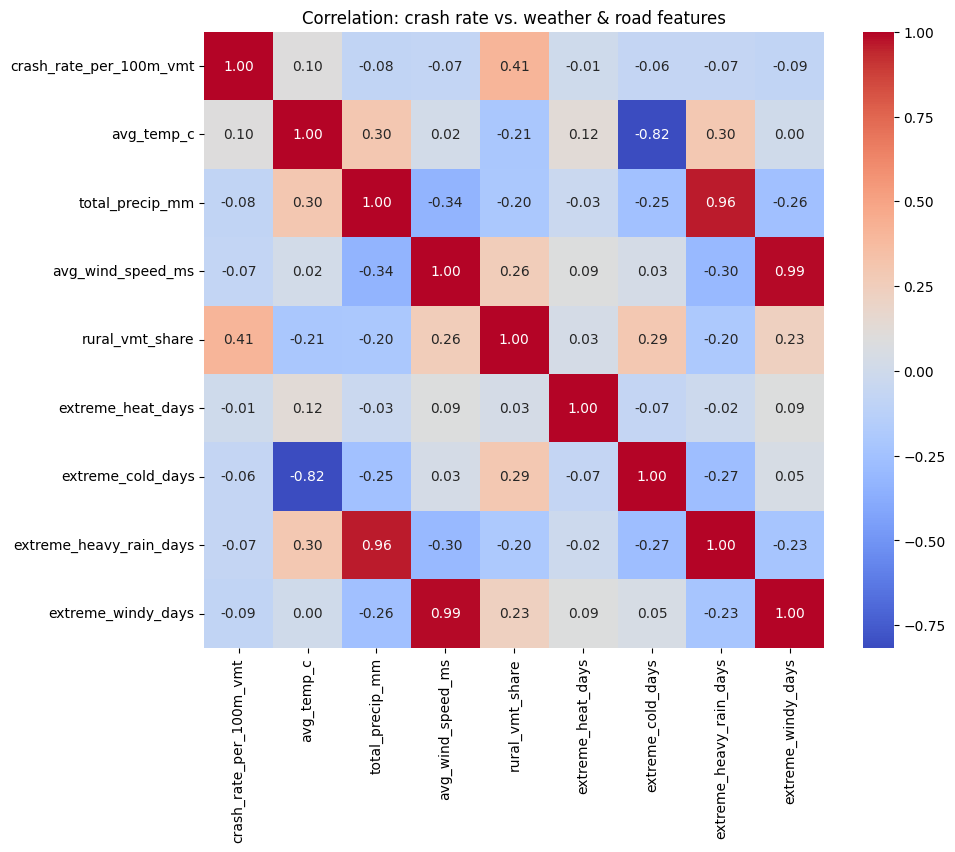

In [19]:
state_full_dir = data_folder / "state_full_json"

extreme_rows = []

HEAT_THRESH = 35      # °C
COLD_THRESH = -10     # °C
RAIN_THRESH = 20      # mm/day
WIND_THRESH = 12      # m/s

for json_file in sorted(state_full_dir.glob("STATE_*_1975_2023.json")):
    with open(json_file, "r") as f:
        obj = json.load(f)
    
    state_id = obj["state_id"]
    lat = obj["latitude"]
    lon = obj["longitude"]
    daily = obj["daily"]
    
    df_daily = pd.DataFrame(daily)
    df_daily["date"] = pd.to_datetime(df_daily["date"])
    df_daily["year"] = df_daily["date"].dt.year
    
    df_daily["is_heat"] = df_daily["temperature_2m_mean"] > HEAT_THRESH
    df_daily["is_cold"] = df_daily["temperature_2m_mean"] < COLD_THRESH
    df_daily["is_heavy_rain"] = df_daily["precipitation_sum"] > RAIN_THRESH
    df_daily["is_windy"] = df_daily["wind_speed_10m_mean"] > WIND_THRESH
    
    grouped = df_daily.groupby("year").agg(
        extreme_heat_days=("is_heat", "sum"),
        extreme_cold_days=("is_cold", "sum"),
        extreme_heavy_rain_days=("is_heavy_rain", "sum"),
        extreme_windy_days=("is_windy", "sum"),
        days_in_year=("date", "count")
    ).reset_index()
    
    grouped["state_id"] = state_id
    grouped["latitude"] = lat
    grouped["longitude"] = lon
    
    extreme_rows.append(grouped)

df_extreme = pd.concat(extreme_rows, ignore_index=True)

print("Extreme-weather features:")

acc_extreme = acc_enriched.merge(
    df_extreme,
    left_on=["state_id", "year"],
    right_on=["state_id", "year"],
    how="left"
)

extreme_out_path = data_folder / "final_accidents_with_rural_and_extremes.csv"
acc_extreme.to_csv(extreme_out_path, index=False)

print("Saved:", extreme_out_path)

df = acc_extreme.copy()

corr_cols = [
    "crash_rate_per_100m_vmt",
    "avg_temp_c",
    "total_precip_mm",
    "avg_wind_speed_ms",
    "rural_vmt_share",
    "extreme_heat_days",
    "extreme_cold_days",
    "extreme_heavy_rain_days",
    "extreme_windy_days"
]

corr = df[corr_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: crash rate vs. weather & road features")
plt.show()


**Conclusion**

The correlation matrix shows that weather variables, as we already discovered, have only weak relationships with fatal crash rates. Average temperature, precipitation, wind speed, and the counts of extreme-weather days all have correlations close to zero, suggesting that annual weather conditions do not really influence fatal crash risk at the state-year level.

The only variable with a noticeable correlation to crash rate is **rural_vmt_share** (0.41). This indicates that states with a larger proportion of rural driving tend to experience higher fatal crash rates - consistent with known patterns of fewer safety features, and longer emergency response times on rural roads.

Overall, the heatmap confirms that **structural and geographic factors** appear more important than weather in explaining differences in fatal crash rates. Although extreme weather events are interesting to examine, they do not show strong linear relationships with crash risk in this aggregated dataset.


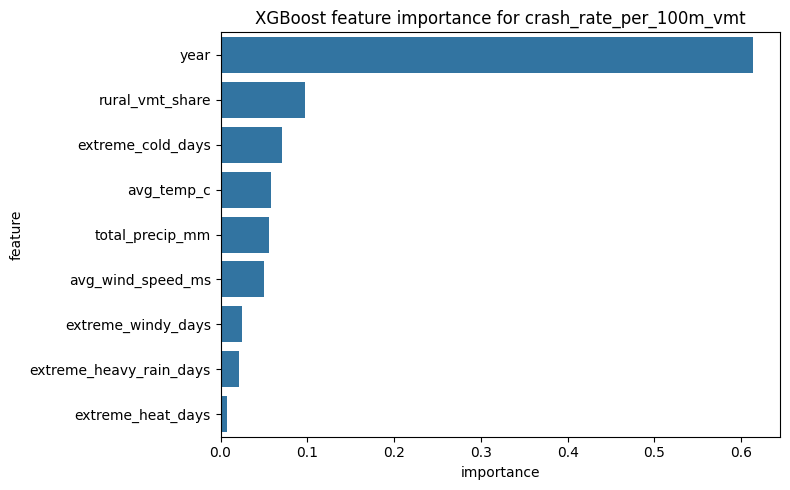

In [20]:
features = [
    "avg_temp_c",
    "total_precip_mm",
    "avg_wind_speed_ms",
    "rural_vmt_share",
    "extreme_heat_days",
    "extreme_cold_days",
    "extreme_heavy_rain_days",
    "extreme_windy_days",
    "year",
]

df_model = acc_extreme.dropna(subset=features + ["crash_rate_per_100m_vmt"]).copy()

X = df_model[features]
y = df_model["crash_rate_per_100m_vmt"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

importances = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=importances, x="importance", y="feature")
plt.title("XGBoost feature importance for crash_rate_per_100m_vmt")
plt.tight_layout()
plt.show()


# Summary

The analysis shows that fatal crash risk is influenced far more by **infrastructure** and **long-term safety improvements** than by weather.

### Key Findings

- **Rural driving** is the strongest consistent predictor of higher crash rates.
- **Year** captures the long-term decline in fatalities due to safer cars, roads, and enforcement.
- Among weather factors, **extreme cold** has the most noticeable impact.
- **Average weather conditions** (temperature, rain, wind) contribute very little.

### Conclusion

Crash risk depends mainly on where and how people drive, not on typical annual weather. Infrastructure and long-term trends dominate, while extreme weather plays only a secondary role.
